In [1]:
!pip install pyarrow

     |████████████████████████████████| 26.7 MB 4.7 MB/s            


In [2]:
!pip3 install torch==1.10.1+cpu  -f https://download.pytorch.org/whl/cpu/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html
     |████████████████████████████████| 199.3 MB 57 kB/s              


In [3]:
!pip3 install transformers

     |████████████████████████████████| 3.5 MB 4.9 MB/s            
     |████████████████████████████████| 596 kB 28.4 MB/s            
     |████████████████████████████████| 67 kB 113 kB/s             
     |████████████████████████████████| 895 kB 48.4 MB/s            
     |████████████████████████████████| 6.8 MB 42.2 MB/s            �█▌            | 4.1 MB 42.2 MB/s eta 0:00:01
     |████████████████████████████████| 748 kB 39.3 MB/s            
     |████████████████████████████████| 306 kB 41.8 MB/s            


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

from transformers import pipeline

In [3]:
import warnings
warnings.filterwarnings("ignore")


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [218]:
fakeNews = pd.read_feather('https://github.com/thousandoaks/TopicsInDataAnalysisDataStore/blob/main/train.ftr?raw=true')

In [219]:
fakeNews.sample(3)

,id,title,author,text,label
13656,13656,What Would an ‘America First’ Foreign Policy L...,Justin Raimondo,Written by Justin Raimondo As Donald Trump t...,1
4421,4421,Five Filipino hostages freed by Somali pirates...,None,"More Filipino fisherman Arnel Balbero (R), who...",1
8668,8668,What Lessons America Can Learn From This Elect...,None,What Lessons America Can Learn From This Elect...,1


# 1. Basic Exploratory Analysis

In [220]:
fakeNews.groupby('label').count()

,id,title,author,text
label,,,,
0,10387,10387,10361,10387
1,10413,9855,8482,10374


## 1.1. Emotion Analysis
### Is there any relationship between emotions and fakeness ?

In [7]:
tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

model = AutoModelForSequenceClassification.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

In [8]:
#classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=False)

In [9]:
fakeNews.dropna(subset=['title'],inplace=True)

In [10]:
fakeNewsSample=fakeNews

In [11]:
#classifier(mini['title'].tolist())

In [12]:
import time
start_time = time.time()
fakeNewsSample['text.classification']=fakeNewsSample['title'].apply(lambda x:classifier(x))

print("--- %s seconds ---" % (time.time() - start_time))

--- 240.59535312652588 seconds ---


In [13]:
fakeNewsSample['emotion.label']=fakeNewsSample['text.classification'].apply(lambda x:x[0]['label'])
fakeNewsSample['emotion.intensity']=fakeNewsSample['text.classification'].apply(lambda x:x[0]['score'])

In [14]:
fakeNewsSample.head(3)

,id,title,author,text,label,text.classification,emotion.label,emotion.intensity
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,"[{'label': 'anger', 'score': 0.961186945438385}]",anger,0.961187
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"[{'label': 'anger', 'score': 0.4854402244091034}]",anger,0.485440
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,"[{'label': 'anger', 'score': 0.9919300079345703}]",anger,0.991930


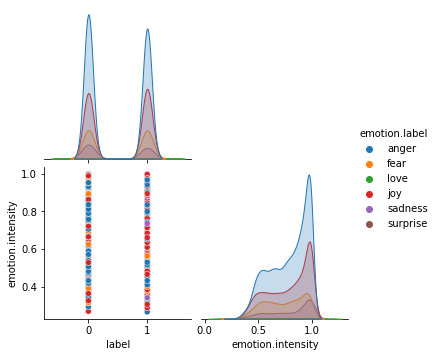

In [15]:
sns.pairplot(fakeNewsSample[['label','emotion.label','emotion.intensity']], hue="emotion.label",corner=True)

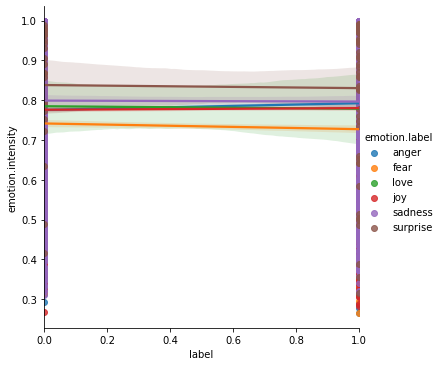

In [16]:
g = sns.lmplot(
    data=fakeNewsSample[['label','emotion.label','emotion.intensity']],
    x="label", y="emotion.intensity", hue="emotion.label",
    height=5
)

## Are emotions useful to spot FakeNews ??
### Tip: have a look at the histograms

## 1.2. text Analysis
### Is there any relationship between text characteristics and fakeness ?

In [17]:
fakeNews['title.length']=fakeNews['title'].apply(lambda x:len(x))

In [18]:
fakeNews.dropna(subset=['text'],inplace=True)

In [19]:
fakeNews['text.length']=fakeNews['text'].apply(lambda x:len(x))

In [20]:
fakeNews[['label','text.length','title.length']].head()

,label,text.length,title.length
0,1,4930,81
1,0,4160,55
2,1,7692,33
3,1,3237,63
4,1,938,93


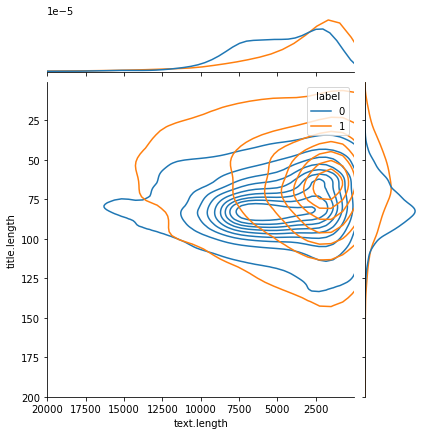

In [21]:
g = sns.jointplot(
    data=fakeNews[['label','text.length','title.length']],
    x="text.length", y="title.length", hue="label",xlim=20000,ylim=200,
    kind="kde",
)

<AxesSubplot:xlabel='text.length', ylabel='Count'>

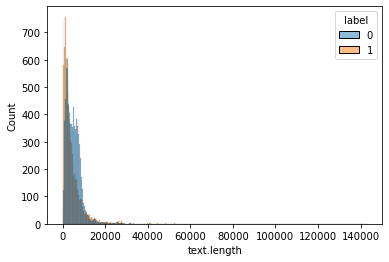

In [31]:
sns.histplot(data=fakeNews[['label','text.length','title.length']], x="text.length", hue="label")

<AxesSubplot:xlabel='title.length', ylabel='Count'>

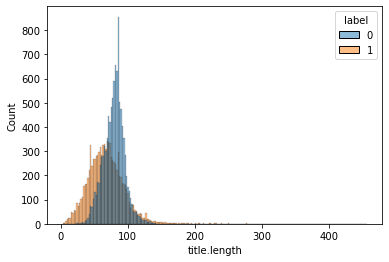

In [33]:
sns.histplot(data=fakeNews[['label','text.length','title.length']], x="title.length", hue="label")

## Thoughts ??

## 1.3. Text readibility

In [34]:
import spacy
from spacy_readability import Readability

In [35]:
nlp2 = spacy.load('en_core_web_sm')

doc = nlp2("I am some really difficult text to read because I use obnoxiously large words.")

In [221]:
fakeNewsSample2=fakeNewsSample

In [ ]:
fakeNewsSample2['text.nlp']=fakeNewsSample2['text'].apply(lambda x:nlp2(x))
fakeNewsSample2['title.nlp']=fakeNewsSample2['title'].apply(lambda x:nlp2(x))

In [ ]:
fakeNewsSample2['text.automated_readability_index']=fakeNewsSample2['text.nlp'].apply(lambda x:x._.automated_readability_index)
fakeNewsSample2['title.automated_readability_index']=fakeNewsSample2['title.nlp'].apply(lambda x:x._.automated_readability_index)

In [ ]:
fakeNewsSample2['text.flesch_kincaid_reading_ease']=fakeNewsSample2['text.nlp'].apply(lambda x:x._.flesch_kincaid_reading_ease)
fakeNewsSample2['title.flesch_kincaid_reading_ease']=fakeNewsSample2['title.nlp'].apply(lambda x:x._.flesch_kincaid_reading_ease)

In [ ]:
sns.pairplot(fakeNewsSample2[['label','text.flesch_kincaid_reading_ease','title.flesch_kincaid_reading_ease','text.automated_readability_index','title.automated_readability_index']], hue="label",corner=True)

## 1.4. Text entities

In [ ]:
text='Hi there, I am in Japan'

In [ ]:
doc=nlp2(text)

In [ ]:
for ent in doc.ents:
    print(ent.text,  ent.label_)

In [ ]:
fakeNewsSample2['title.entities']=fakeNewsSample2['title.nlp'].apply(lambda x:[e.label_ for e in x.ents])


In [ ]:
fakeNewsSample2[fakeNewsSample2['label']==0]['title.entities']

In [ ]:
notFakeEntities=pd.DataFrame()
notFakeEntities['entity']=fakeNewsSample2[fakeNewsSample2['label']==0]['title.entities'].explode()
notFakeEntities['label']=0

In [ ]:
FakeEntities.head(3)

In [ ]:
FakeEntities=pd.DataFrame()
FakeEntities['entity']=fakeNewsSample2[fakeNewsSample2['label']==1]['title.entities'].explode()
FakeEntities['label']=1

In [ ]:
FakeEntities.head(3)

In [ ]:
notFakeEntities.groupby('entity').count().reset_index()

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot( x='entity',y='label',data=notFakeEntities.groupby('entity').count().reset_index())

In [ ]:
FakeEntities.groupby('entity').count()

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot( x='entity',y='label',data=FakeEntities.groupby('entity').count().reset_index())

# Thoughts ??